In [ ]:
'''-----feature engineering-----'''

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

In [2]:
filename = 'NAB-master/data/realKnownCause/ambient_temperature_system_failure.csv'
#performing the Non-Standart Missing Values checking
missing_values = ["n/a", "na", "--"]
initial = pd.read_csv(filename, na_values = missing_values)
df = initial.copy()

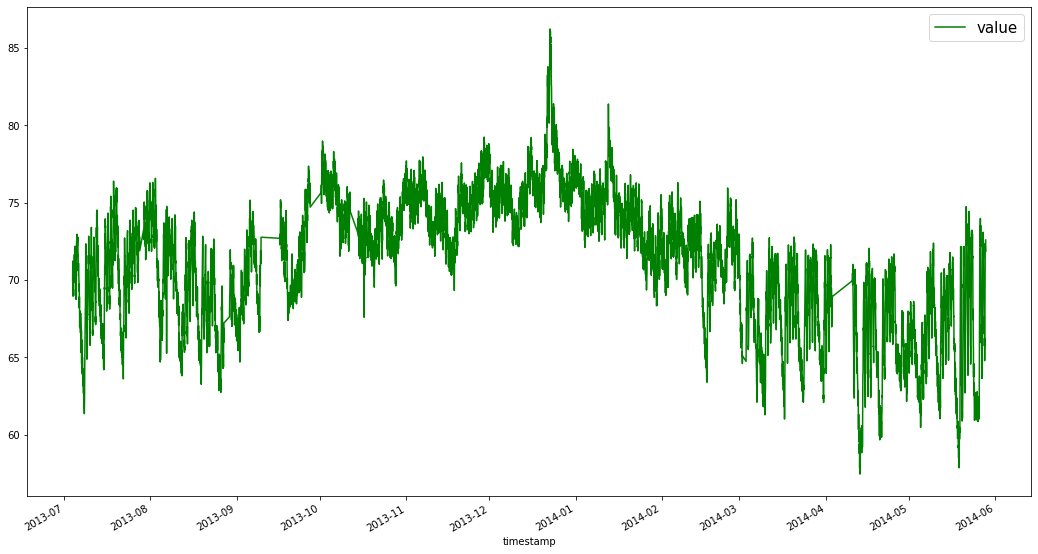

In [3]:
#plotting the data; 
initial['timestamp'] = pd.to_datetime(initial['timestamp'])
initial.plot(x='timestamp',x_compat=True,style='g', figsize=(18, 10))
plt.legend(fontsize=15)

In [4]:
initial.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


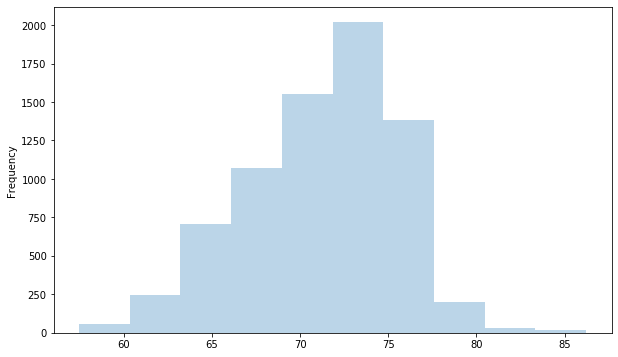

In [5]:
plt.figure()
initial['value'].plot.hist(alpha=0.3, figsize=(10,6))

In [6]:
# dealing with features; adding hours, weekday etc
def season_of_date(day):
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    # winter = everything else

    if day in spring:
        return 1 #'spring'
    elif day in summer:
        return 2 #'summer'
    elif day in fall:
        return 3 #'fall'
    else:
        return 4 #'winter'

datepoints = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')
df['hours'] = datepoints.dt.hour
df['weekday'] = datepoints.dt.weekday
# df['daylight'] = ...extract here the daylight info using time.daylight; problem: cannot access the whole series as its type is datetime64[ns]
# df['daylight'] = datepoints.dt.time.daylight ???
df['isweekend'] = df['weekday']>=5
df['dayofyear'] = datepoints.dt.dayofyear
df['year'] = datepoints.dt.year
df['season'] = datepoints.dt.dayofyear.map(season_of_date)
df['month'] = datepoints.dt.month
df

,timestamp,value,hours,weekday,isweekend,dayofyear,year,season,month
0,2013-07-04 00:00:00,69.880835,0,3,False,185,2013,2,7
1,2013-07-04 01:00:00,71.220227,1,3,False,185,2013,2,7
2,2013-07-04 02:00:00,70.877805,2,3,False,185,2013,2,7
3,2013-07-04 03:00:00,68.959400,3,3,False,185,2013,2,7
4,2013-07-04 04:00:00,69.283551,4,3,False,185,2013,2,7
...,...,...,...,...,...,...,...,...,...
7262,2014-05-28 11:00:00,72.370206,11,2,False,148,2014,1,5
7263,2014-05-28 12:00:00,72.172956,12,2,False,148,2014,1,5
7264,2014-05-28 13:00:00,72.046565,13,2,False,148,2014,1,5
7265,2014-05-28 14:00:00,71.825226,14,2,False,148,2014,1,5


In [7]:
# now we're gonna compare the values through the days (for 2013)
df_2013 = df[df['year']==2013]
df_2013
df_by_hours_2013 = df_2013.pivot(index="hours", columns="dayofyear", values="value")

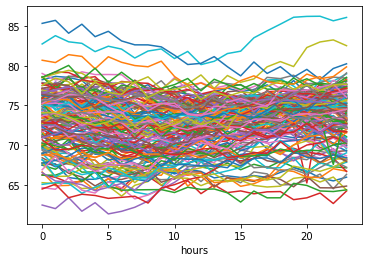

In [8]:
df_by_hours_2013.plot(legend=False)
# so there's very uninformative plot as it is too much info, even for a half of a year

<BarContainer object of 11 artists>

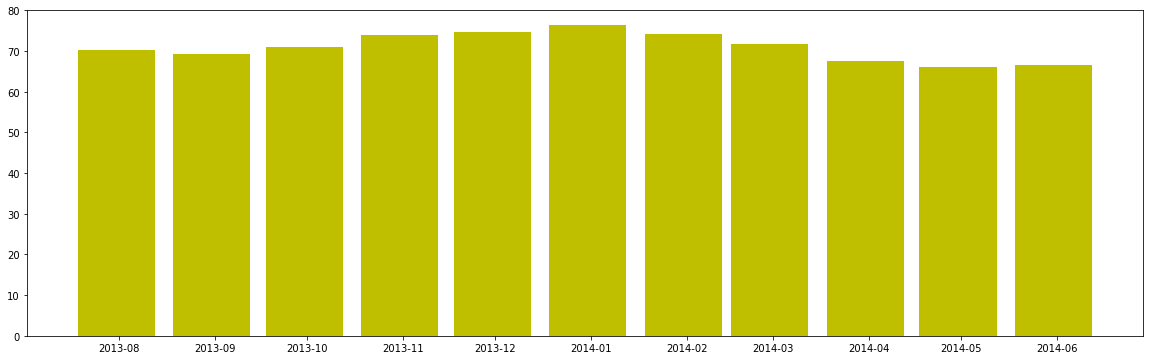

In [9]:
# bar plot by months
#reindexing 
df_ri_ts = pd.DataFrame(data=list(df['value']), index=datepoints, columns=['value'])
df_month = df_ri_ts.resample("M").mean()
#print(df_month)

fig, ax = plt.subplots(figsize=(20, 6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.bar(df_month.index, df_month.loc[:, "value"], width=25, align='center', color='y')

<BarContainer object of 329 artists>

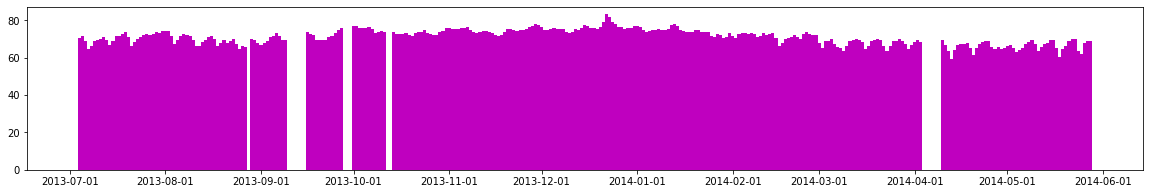

In [10]:
# bar plot by days
#reindexing 
df_day = df_ri_ts.resample("D").mean()

fig, ax = plt.subplots(figsize=(20, 3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.bar(df_day.index, df_day.loc[:, "value"], width=1, align='center', color='m')

In [11]:
df_ri_ts.isnull().values.any()

False

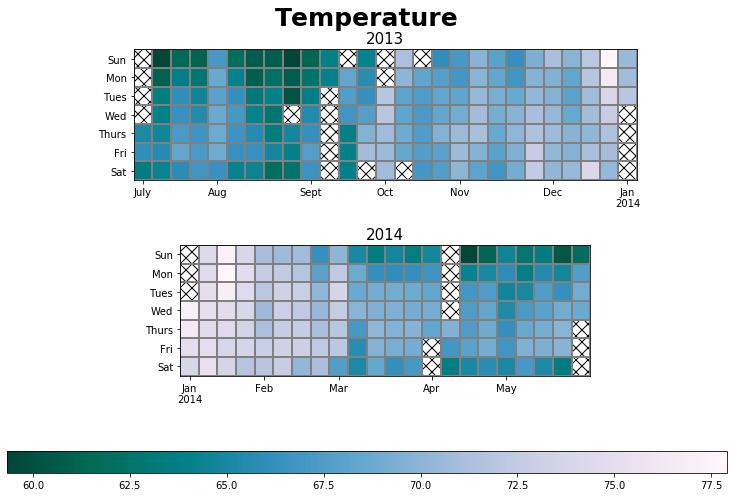

In [12]:
# heatmap code found and adapted from https://vietle.info/post/calendarheatmap-python/
df_day = df_ri_ts.resample("D").mean()
df_day.index = pd.to_datetime(df_day.index)

from matplotlib import colors

# Turn data frame to a dictionary for easy access
cal = {'2013': df_day[df_day.index.year == 2013], '2014': df_day[df_day.index.year == 2014]}

# Define Ticks
DAYS = ['Sun', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat']
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

#creating heatmaps
fig, ax = plt.subplots(2, 1, figsize = (20,6))
for i, val in enumerate(['2013', '2014']):
    #print(cal.get(val))
    start = cal.get(val).index.min()
    end = cal.get(val).index.max()
    start_sun = start - np.timedelta64((start.dayofweek + 1) % 7, 'D')
    end_sun =  end + np.timedelta64(7 - end.dayofweek -1, 'D')

    num_weeks = (end_sun - start_sun).days // 7
    heatmap = np.full([7, num_weeks], np.nan)
    ticks = {}
    y = np.arange(8) - 0.5
    x = np.arange(num_weeks + 1) - 0.5
    for week in range(num_weeks):
        for day in range(7):
            date = start_sun + np.timedelta64(7 * week + day, 'D')
            if date.day == 1:
                ticks[week] = MONTHS[date.month - 1]
            if date.dayofyear == 1:
                ticks[week] += f'\n{date.year}'
            if start <= date <= end:
                heatmap[day, week] = cal.get(val).loc[date, 'value']
                #print(day, week, cal.get(val).loc[date, 'value'])
    mesh = ax[i].pcolormesh(x, y, heatmap, cmap = 'PuBuGn_r', edgecolors = 'grey')

    ax[i].invert_yaxis()

    # Set the ticks.
    ax[i].set_xticks(list(ticks.keys()))
    ax[i].set_xticklabels(list(ticks.values()))
    ax[i].set_yticks(np.arange(7))
    ax[i].set_yticklabels(DAYS)
    ax[i].set_ylim(6.5,-0.5)
    ax[i].set_aspect('equal')
    ax[i].set_title(val, fontsize = 15)

    # Hatch for out of bound values in a year
    ax[i].patch.set(hatch='xx', edgecolor='black')

# Add color bar at the bottom
cbar_ax = fig.add_axes([0.25, -0.10, 0.5, 0.05])
fig.colorbar(mesh, orientation="horizontal",  pad=0.2, cax = cbar_ax)
colorbar = ax[1].collections[0].colorbar
r = colorbar.vmax - colorbar.vmin
fig.suptitle('Temperature', fontweight = 'bold', fontsize = 25)
fig.subplots_adjust(hspace = 0.5)

#!!! deal with xx - cells

In [11]:
# this visualization also shows if there are missing days in dataset!

In [12]:
# ideas for further visualisation:
# compare (average) weekends and business days
# appply other on-built types of plots

In [13]:
#split data into train and test dataset

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df)
df_train
df_test

,timestamp,value,hours,weekday,isweekend,dayofyear,year,season,month
2706,2013-11-10 13:00:00,72.073684,13,6,True,314,2013,3,11
3655,2013-12-20 02:00:00,76.249503,2,4,False,354,2013,3,12
1180,2013-08-23 12:00:00,70.722135,12,4,False,235,2013,2,8
4491,2014-01-23 22:00:00,74.527536,22,3,False,23,2014,4,1
990,2013-08-15 14:00:00,72.696104,14,3,False,227,2013,2,8
...,...,...,...,...,...,...,...,...,...
2145,2013-10-18 04:00:00,72.453902,4,4,False,291,2013,3,10
1310,2013-08-30 21:00:00,70.096222,21,4,False,242,2013,2,8
4288,2014-01-15 11:00:00,74.153357,11,2,False,15,2014,4,1
2075,2013-10-15 06:00:00,72.204553,6,1,False,288,2013,3,10


In [ ]:
"""------data preprocessing-----"""

In [14]:
# find and filter out missing and incorrect values
#Missing Values
print('subdataframe with missing timestamp: \n',df[df['timestamp'].isnull()],'\n')
print('subdataframe with missing value: \n',df[df['value'].isnull()], '\n')
print('total missings by feature:\n',df.isnull().sum())
print('if there\'s any missing value:\n', df.isnull().values.any())

subdataframe with missing timestamp: 
 Empty DataFrame
Columns: [timestamp, value, hours, weekday, isweekend, dayofyear, year, season, month]
Index: [] 

subdataframe with missing value: 
 Empty DataFrame
Columns: [timestamp, value, hours, weekday, isweekend, dayofyear, year, season, month]
Index: [] 

total missings by feature:
 timestamp    0
value        0
hours        0
weekday      0
isweekend    0
dayofyear    0
year         0
season       0
month        0
dtype: int64
if there's any missing value:
 False


In [14]:
#Incorrect Values
#Assuming there's value in incorrect format unifying it
from numpy import nan
i = 0
for row in df['value']:
    try:
        float(row)
    except ValueError:
        df.loc[cnt, 'value'] = nan
    i += 1
print(df.isnull().values.any())

False


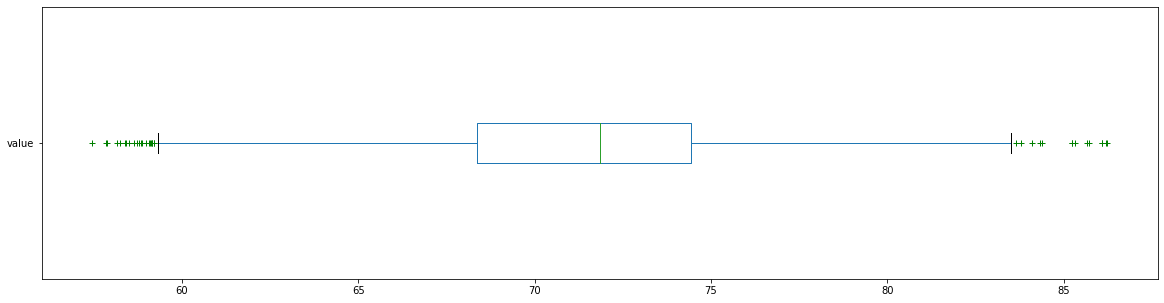

In [15]:
#discover outliers
#box plot
df['value'].plot.box(vert=False,sym="g+", figsize=(20, 5))

#so here we observe a set of low-temperatue values and high, but as they're not so distanced from median, I suppose it just caused by seasonal wavering

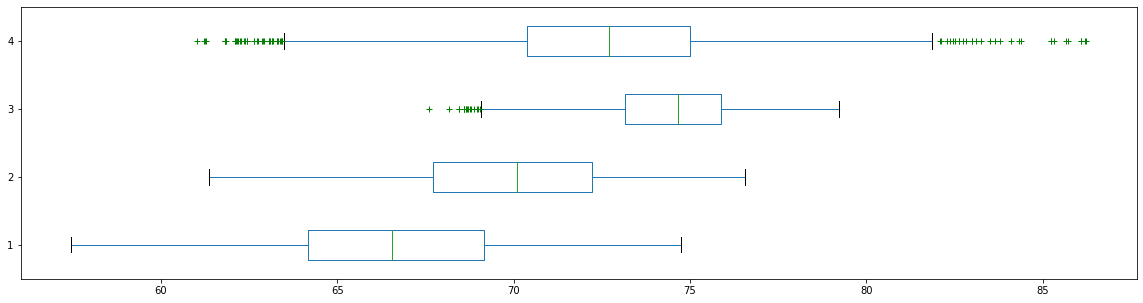

In [34]:
#lets discrete the values by season
seasons = ['spring', 'summer', 'fall', 'winter']

df_seasons = df.pivot(columns="season", values="value")

df_seasons.plot.box(vert=False,sym="g+", figsize=(20, 5))

#i did not come across with fancier indexing, lucky me box plotting ignores NA values...
#however, it might be so unexpected that summer and spring are cooler in average

In [35]:
#z-score
# The Z-score is the signed number of standard deviations 
# by which the value of an observation or data point is above 
# the mean value of what is being observed or measured.

from scipy import stats
import numpy as np
z = np.abs(stats.zscore(df['value']))
threshold = 3
print(np.where(z > 3)) #now we have an array with all the outliners indexes, for example:
print(df.loc[3718])
#I suppose that it is not a one-hint outliners, as there are several inline indexes! The values are smooth

(array([3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728,
       3730, 6177, 6178, 6180, 6181, 7034, 7035, 7036], dtype=int64),)
timestamp    2013-12-22 17:00:00
value                    84.3909
hours                         17
weekday                        6
isweekend                   True
dayofyear                    356
year                        2013
season                         4
month                         12
Name: 3718, dtype: object


In [36]:
#IQR
# The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical 
# dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.
# In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box 
# plot on the data.
# It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)
df[(df['value'] < (Q1 - 1.5 * IQR)) |(df['value'] > (Q3 + 1.5 * IQR))].count() #the dataframe that contains all the outliners

6.061547350000012


timestamp    35
value        35
hours        35
weekday      35
isweekend    35
dayofyear    35
year         35
season       35
month        35
dtype: int64

In [37]:
#so there are missing days in  our dataset. lets find them out
#creating test list
dp_lst = datepoints.to_list()

delta = dp_lst[-1] - dp_lst[0]
print(delta.components)
periods = delta.components[0]*24+delta.components[1]+1
# print(periods)
test_s = pd.date_range(dp_lst[0], periods=periods, freq="H")
test_lst = test_s.to_list()
#difference
missing_lst = list(set(test_lst) - set(dp_lst))

Components(days=328, hours=15, minutes=0, seconds=0, milliseconds=0, microseconds=0, nanoseconds=0)


In [ ]:
'''------K-Means Clustering--------'''

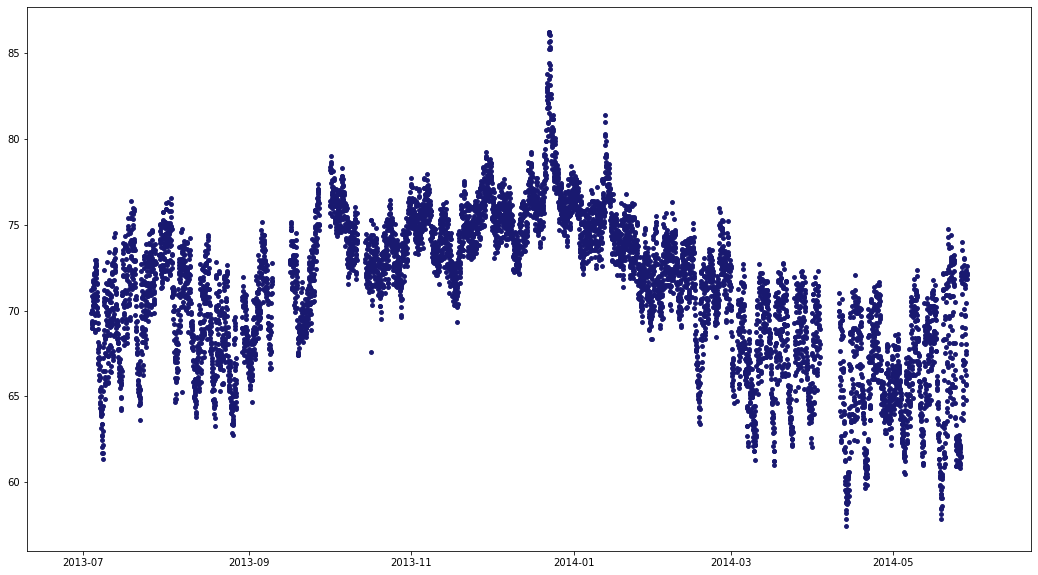

In [38]:
#from pandas.tools.plotting import scatter_plot
plt.figure(figsize=(18,10))
plt.scatter(datepoints, df.value, s=15,c='MidnightBlue')

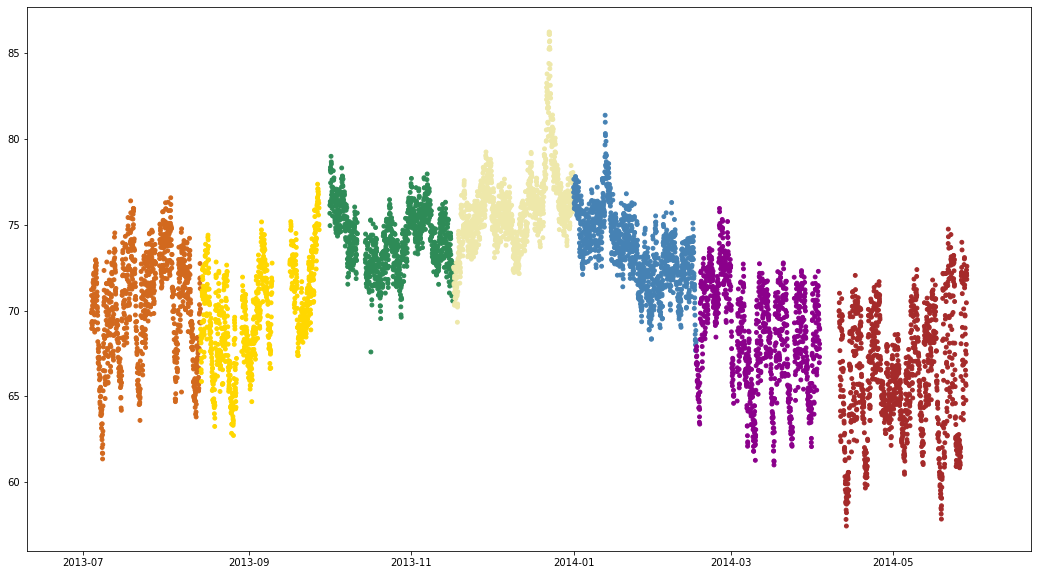

In [39]:
from sklearn.cluster import KMeans

df['timestamp'] = pd.to_datetime(df['timestamp'])
# Fit the data into KMean model, default params are
# KMeans(copy_x=True, init='k-means++', max_iter=300,
#        n_clusters=3, n_init=10, n_jobs=1,
#        precompute_distances='auto',
#        random_state=None, tol=0.0001, verbose=0)
model = KMeans(n_clusters=7, max_iter=300)
model.fit(df.loc[:,'value':'month'])

# Plot the First iteration of the kmean.
colormap = np.array(['SeaGreen', 'SteelBlue', 'Brown','Chocolate', 'PaleGoldenRod','DarkMagenta','Gold'])
plt.figure(figsize=(18,10))
plt.scatter(datepoints, df.value, c=colormap[model.labels_], s=15)

In [48]:
# PCA
from sklearn.decomposition import PCA

X = df_train.copy().loc[:,'value':'month']
X.isnull().sum()

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
new_df = pd.DataFrame(X_r, columns=['feature1', 'feature2'])

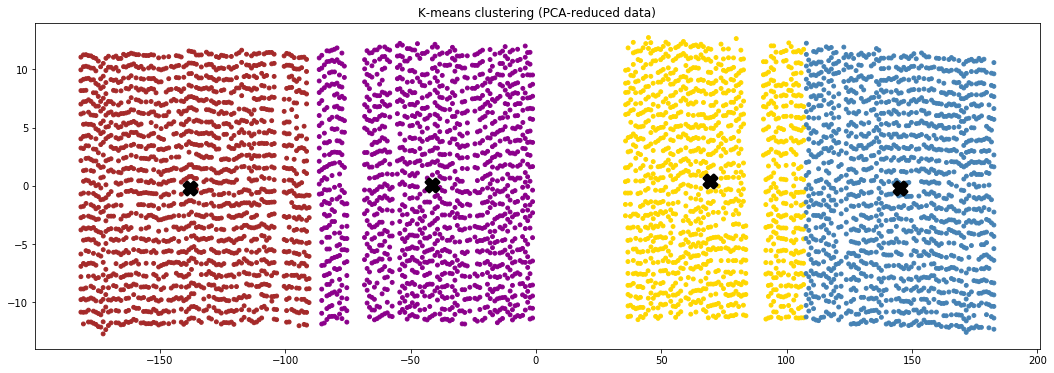

In [49]:
# Clusters visualisation 

# Cluste size.
K = 4
MAX_ITER = 100;

# Kmean model.
model = KMeans(n_clusters=K, max_iter=MAX_ITER)

model.fit(X_r)

colormap = np.array(['SteelBlue', 'Brown','DarkMagenta','Gold', 'red'])
plt.figure(figsize=(18,6))
plt.scatter(X_r[:,0], X_r[:,1], c=colormap[model.labels_], s=15)

# Plot the centroids as a black X

centroids = model.cluster_centers_
new_df['class'] = model.labels_

plt.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=169, linewidths=3,
            color="k")
plt.title("K-means clustering (PCA-reduced data)")
plt.show()

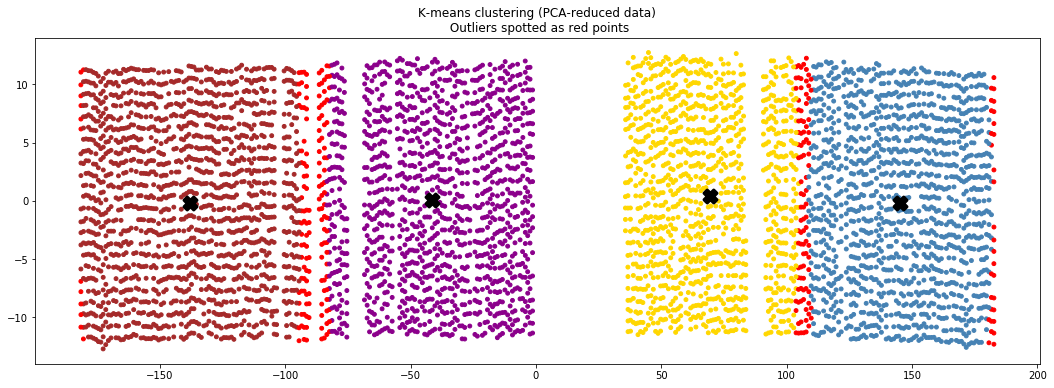

In [51]:
# finding outliers
import math
OUT_PER = 0.05 # persentage of points that have greatest distance and are taken as anomalies


def distance(x, y):
    """
    Find distance between two points in a plain
    x: 2D point.
    y: 2D point.
    
    return euclidean distance between this points
    """
    d1 = x[0] - y[0];
    d2 = x[1] - y[1];
    distance = math.sqrt(d1*d1 + d2*d2)
    return distance


def get_outliers(df):
    """
    Reorganize the dataframe and assign to outliers the new class = K that will be plotted in red 
    All the outliers must be calculated within one class 
    The Anomaly rule:
    OUT_PER% of points that have greatest distance from centroid or their cluster are anomalies
    
    df: DataFrame with columns=['feature1', 'feature2', 'class'], class is integer from 0 to K-1
    return reorganized r_df 
    """
    r_df = df.copy()
    r_df['distance'] = [distance([r_df.loc[x,'feature1'],r_df.loc[x,'feature2']], centroids[r_df.loc[x,'class']]) for x in r_df.index]
    outliers = []
    for cls in r_df['class'].unique():
        df_cls = r_df[df['class'] == cls]
        low_bound = round(len(df_cls.index)*(1 - OUT_PER))
        df_srtd = df_cls.sort_values(by=['distance'])
        #print(df_srtd)
        outliers_cls = df_srtd[low_bound:]
        outliers+=list(outliers_cls.index.to_numpy())
    #print(len(outliers))
    r_df.loc[outliers,'class'] = K
        
    return r_df

# get_outliers(new_df)

# plotting
plt.figure(figsize=(18,6))
plt.scatter(X_r[:,0], X_r[:,1], c=colormap[get_outliers(new_df)['class']], s=15)

# Plot the centroids as a black X

centroids = model.cluster_centers_
new_df['class'] = model.labels_

plt.scatter(centroids[:, 0], centroids[:, 1], marker="X", s=169, linewidths=3,
            color="k")
plt.title("K-means clustering (PCA-reduced data)\n Outliers spotted as red points")
plt.show()